Please use the following conda environment:

`/work/PRTNR/CHUV/DIR/rgottar1/single_cell_all/conda_envs/img_registration`

In [45]:
import os
import json

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import pyvips

import spatialdata_io as sdio
import spatialdata_plot 

from shapely.geometry import shape
from shapely.geometry.base import BaseGeometry
from shapely.geometry import Polygon
from pathlib import Path

import sys
sys.path.append("../../scripts/")
import alignment
import readwrite
cfg = readwrite.config()


def geojson_to_gdf(geojson_list):
    gdf = gpd.GeoDataFrame(
        [feature["properties"] for feature in geojson_list],  # Extract properties as DataFrame
        geometry=[shape(feature["geometry"]) for feature in geojson_list]  # Convert geometry
    )
    return gdf

def to_geojson(geojson,save_path):
    with open(
        save_path,
        "w",
        encoding="utf-8",
    ) as fh:
        json.dump(
            {
                "type": "FeatureCollection",
                "features": geojson,
            },
            fh,
            separators=(",", ":"),
            indent=4,
        )

def _parse_version_of_xenium_analyzer_patch(specs, hide_warning=True):
    import packaging.version
    return packaging.version.parse("2.0.0")

# Params

In [46]:
# Base paths
results_dir = cfg['results_dir']
xenium_processed_data_dir = cfg['xenium_processed_data_dir']

# Parameters
segmentation = "10x_5um"
condition = 'NSCLC'
panel = 'chuvio'
donor = '0PSV'
sample = '0PSV_1'
imaging = 'HnE'#'IF'

k = (segmentation, condition, panel, donor, sample)
name = '/'.join(k)

# Path to the transformation matrix
transform_mtx_path = Path(f"/work/PRTNR/CHUV/DIR/rgottar1/spatial/data/xenium_paper/IHC/alignment_files/{panel}_{sample}_{imaging}_matrix.csv")

# Path to the Xenium output folder.
raw_data_path = xenium_processed_data_dir + f"{name}/normalised_results/outs"

# Path to the raw image
raw_image_path = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/data/xenium_paper/HnE/pictures/HE - Before and after Xenium/HE after Xenium test slides/Run X5/Xenium 4006 - 2023-10-04 18.14.46.ndpi"

# Path to the raw cellvit segmentation
raw_seg_path = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/data/xenium_paper/xenium/cellvitpp/lung_0PSV/raw/Xenium 4006 - 2023-10-04 18_cells.geojson"

# output path to the transformed cell polygon file.
align_keys = ["cell_boundaries", "nucleus_boundaries"]
geojson_paths = {k: results_dir + f"xenium_image_alignment/{name}/{transform_mtx_path.stem}_{k}_aligned.geojson"
                    for k in align_keys}

# output path to the cellvit transformed cell polygon file.
out_cellvitpp_nucleus_boundaries_path =  results_dir+f"xenium_image_alignment/{name}/{transform_mtx_path.stem}_cellvitpp_nucleus_boundaries.geojson"

# output path to the cellvit / xenium intersection cell polygon file.
out_cell_boundaries_overlay_path =  results_dir+f"xenium_image_alignment/{name}/{transform_mtx_path.stem}_cellvitpp_nucleus_boundaries_xenium_overlay.geojson"
out_cell_boundaries_overlay_path_parquet =  Path(out_cell_boundaries_overlay_path).with_suffix(".parquet")

In [16]:
# # Base paths
# results_dir = cfg['results_dir']
# xenium_processed_data_dir = cfg['xenium_processed_data_dir']

# # Parameters
# segmentation = "10x_5um"
# condition = 'breast'
# panel = 'breast'
# donor = '1FHZ'
# sample = '1FHZ'

# k = (segmentation, condition, panel, donor, sample)
# name = '/'.join(k)

# # Path to the Xenium output folder.
# raw_data_path = xenium_processed_data_dir + f"{name}/normalised_results/outs"

# # output path to the transformed cell polygon file.
# align_keys = ["cell_boundaries", "nucleus_boundaries"]
# geojson_paths = {k: results_dir + f"xenium_image_alignment/{name}/{k}.geojson"
#                     for k in align_keys}

# Load data

In [17]:
# Load xenium segmentation output
sdio.readers.xenium._parse_version_of_xenium_analyzer = (
    _parse_version_of_xenium_analyzer_patch
)

sdata = readwrite.read_xenium_sample(
    raw_data_path,
    cells_boundaries=True,
    nucleus_boundaries=True,
    morphology_focus=True,
    cells_table=False
)

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


In [18]:
# Load transform matrix
transform_mtx = pd.read_csv(transform_mtx_path, header=None).values
inv_transform_mtx = np.linalg.inv(transform_mtx)

In [19]:
# Load image
raw_image = pyvips.Image.new_from_file(raw_image_path)
raw_image.width, raw_image.height, raw_image.xres, raw_image.yres

(51968, 32256, 2261.10009765625, 2261.10009765625)

In [20]:
# Load cellvit segmentation
cellvitpp_nucleus_boundaries = gpd.read_file(raw_seg_path)

# Align and save cell boundaries as geojson

In [21]:
# Align cell, nucleus boundaries

boundaries_aligned = {}
for align_key in align_keys:
    if align_key in sdata:
        boundaries_aligned[align_key] = alignment.process_raw_boundaries(
            sdata[align_key],
            object_type="detection",
            transform_mtx=inv_transform_mtx,
            mat_mul_func=alignment.transform_mtx_by_coords,
            first_n=None,
        )

# Save
for align_key in boundaries_aligned.keys():
    geojson_path = geojson_paths[align_key]

    if not os.path.exists(os.path.dirname(geojson_path)):
        os.makedirs(os.path.dirname(geojson_path))

    to_geojson(boundaries_aligned[align_key],geojson_path)

# Split cells from multiple samples on the same H&E image

## Check Xenium image

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


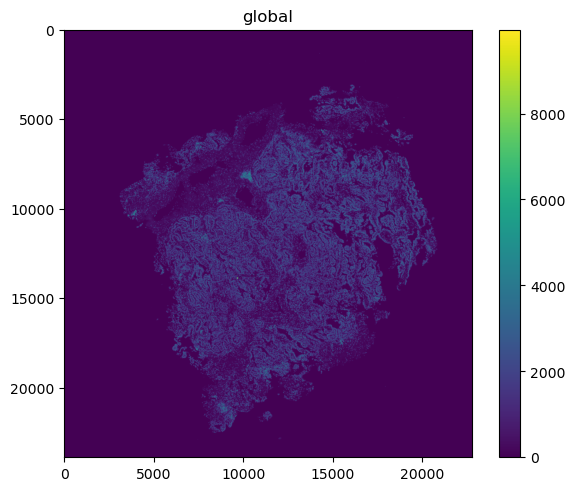

In [15]:
sdata.pl.render_images().pl.show()

## Split the original image

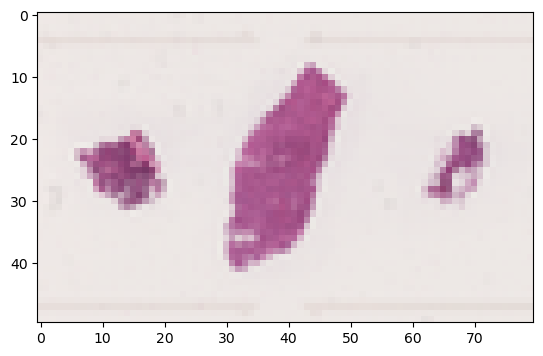

In [14]:
plt.imshow(raw_image.thumbnail_image(80).numpy())

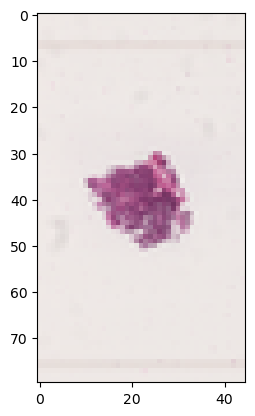

In [13]:
left_image = raw_image.crop(0, 0, 18000, 32256)
plt.imshow(left_image.thumbnail_image(80).numpy())

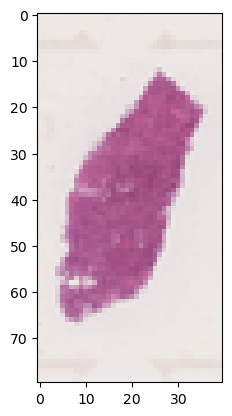

In [8]:
middle_image = raw_image.crop(18000, 0, 16000, 32256)
plt.imshow(middle_image.thumbnail_image(80).numpy())

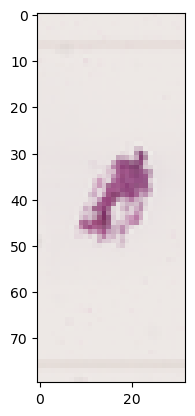

In [11]:
right_image = raw_image.crop(37000, 0, 13000, 32256)
plt.imshow(right_image.thumbnail_image(80).numpy())

In [22]:
regions: dict[str, BaseGeometry] = {
    "left": Polygon(
        [
            (0, 0),
            (18000, 0),
            (18000, 32256),
            (0, 32256),
            (0, 0),
        ],
    ),
    "middle": Polygon(
        [
            (18000, 0),
            (34000, 0),
            (34000, 32256),
            (18000, 32256),
            (18000, 0),
        ],
    ),
    "right": Polygon(
        [
            (37000, 0),
            (50000, 0),
            (50000, 32256),
            (37000, 32256),
            (37000, 0),
        ],
    ),
}

regions[sample] = regions['left']

## Split cellvit cell boundaries

In [23]:
# assign to regions
assigned_data = alignment.split_cells_from_samples(
    cellvitpp_nucleus_boundaries,
    regions,
).query(
    'in_regions == True',
).drop(
    columns=["in_regions"],
).reset_index(
    None,
    drop=True,
)


# save
if not os.path.exists(os.path.dirname(out_cellvitpp_nucleus_boundaries_path)):
    os.makedirs(os.path.dirname(out_cellvitpp_nucleus_boundaries_path))

pd.merge(
    cellvitpp_nucleus_boundaries,
    assigned_data.query(
        f"`{sample}` == True",
    ).drop(
        columns=list(regions.keys()),
    ),
    on="id",
    how="inner",
).to_file(
    out_cellvitpp_nucleus_boundaries_path,
    driver='GeoJSON'
)

# Intersect xenium and cellvit boundaries

In [ ]:
# convert to gdf
boundaries_aligned_gdf = {k:
    geojson_to_gdf(v) for k,v in boundaries_aligned.items()}

# select xenium nuclei boundaries to overlay
xenium_aligned_nucleus_boundaries = boundaries_aligned_gdf['nucleus_boundaries']

# clarify names for cell id columns
xenium_aligned_nucleus_boundaries['xenium_cell_id'] = xenium_aligned_nucleus_boundaries['name']
cellvitpp_nucleus_boundaries['cellvitpp_cell_id'] = cellvitpp_nucleus_boundaries['id']

# extra cols to retain original geometries on overlay
xenium_aligned_nucleus_boundaries['xenium_geometry'] = xenium_aligned_nucleus_boundaries['geometry']
cellvitpp_nucleus_boundaries['cellvitpp_geometry'] = cellvitpp_nucleus_boundaries['geometry']

# overlay boundaries
df_nucleus_boundaries_overlay = xenium_aligned_nucleus_boundaries.overlay(cellvitpp_nucleus_boundaries)

# df_nucleus_boundaries_overlay = df_nucleus_boundaries_overlay.merge(xenium_aligned_nucleus_boundaries[["xenium_cell_id","xenium_geometry"]],on='xenium_cell_id')
# df_nucleus_boundaries_overlay = df_nucleus_boundaries_overlay.merge(cellvitpp_nucleus_boundaries[["cellvitpp_cell_id","cellvitpp_geometry"]],on='cellvitpp_cell_id')

# add area
df_nucleus_boundaries_overlay['area'] = df_nucleus_boundaries_overlay['geometry'].area
df_nucleus_boundaries_overlay['xenium_area'] = df_nucleus_boundaries_overlay['xenium_geometry'].area
df_nucleus_boundaries_overlay['cellvitpp_area'] = df_nucleus_boundaries_overlay['cellvitpp_geometry'].area

# save overlay
if not os.path.exists(os.path.dirname(out_cell_boundaries_overlay_path)):
    os.makedirs(os.path.dirname(out_cell_boundaries_overlay_path))

save_columns = ['xenium_cell_id','cellvitpp_cell_id','classification','geometry',"area"]
df_nucleus_boundaries_overlay[save_columns].to_file(out_cell_boundaries_overlay_path)

save_columns += ["xenium_geometry","cellvitpp_geometry","xenium_area","cellvitpp_area"]
df_nucleus_boundaries_overlay[save_columns].to_parquet(out_cell_boundaries_overlay_path_parquet)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/geopandas/geodataframe.py:2675: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.overlay(
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 1388 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/tmp/ipykernel_2819322/3469798337.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_nucleus_boundaries_overlay['cellvitpp_area'] = df_nucleus_

ValueError: GeoDataFrame contains multiple geometry columns but GeoDataFrame.to_file supports only a single geometry column. Use a GeoDataFrame.to_parquet or GeoDataFrame.to_feather, drop additional geometry columns or convert them to a supported format like a well-known text (WKT) using `GeoSeries.to_wkt()`.